
===== Channel Gains =====
Pair 1:
h1: 1.3408 (weaker user to BS)
h2: 2.4923 (stronger user to BS)
h1e: 2.5273 (stronger user to Eve)
h2e: 0.6687 (weaker user to Eve)
Pair 2:
h1: 0.9357 (weaker user to BS)
h2: 1.0855 (stronger user to BS)
h1e: 1.8596 (stronger user to Eve)
h2e: 1.5062 (weaker user to Eve)
Pair 3:
h1: 2.0069 (weaker user to BS)
h2: 4.1092 (stronger user to BS)
h1e: 2.0892 (stronger user to Eve)
h2e: 1.0248 (weaker user to Eve)
Boosting User 1 in Pair 3 with +0.2121W
Transferred 0.1071W from User 2 to User 1 in Pair 3
Boosting User 1 in Pair 3 with +0.2799W
Transferred 0.1414W from User 2 to User 1 in Pair 3
Emergency fix: Transferred 0.2143W from Pair 1 User 2 to Pair 3 User 1
Enforcing reverse NOMA principle for Pair 1: Adjusted P1=1.1428, P2=1.7142
Enforcing reverse NOMA principle for Pair 2: Adjusted P1=2.1517, P2=3.2275
Reverse NOMA enforcement for Pair 3 would cause constraint violation for User 1.
Found balanced solution for Pair 3: P1=1.6526, P2=1.9401, SR1=0.312

<ipython-input-1-92680c150753>:1172: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_q, target.detach())


Streaming output truncated to the last 5000 lines.
Enforcing reverse NOMA principle for Pair 2: Adjusted P1=1.6869, P2=2.5303
Reverse NOMA enforcement for Pair 3 would cause constraint violation for User 1.
Found balanced solution for Pair 3: P1=1.8197, P2=2.2241, SR1=0.3044
Total power allocation: 20.0000W
Sum of all power thresholds: 20.0000W
Episode: 330, Total Reward: 540.95, Total SR: 7.73
Legitimate Rate: 8.78, Eavesdropper Rate: 1.05
Total Power: 20.0000W, Constraint Satisfaction: 100.0%
Sum of Power Thresholds: 20.0000W
---
Enforcing reverse NOMA principle for Pair 1: Adjusted P1=1.5093, P2=2.2640
Enforcing reverse NOMA principle for Pair 2: Adjusted P1=1.3581, P2=2.0372
Reverse NOMA enforcement for Pair 3 would cause constraint violation for User 1.
Found balanced solution for Pair 3: P1=1.5981, P2=1.9532, SR1=0.3246
Total power allocation: 20.0000W
Sum of all power thresholds: 20.0000W
Boosting User 1 in Pair 1 with +0.1840W
Transferred 0.0835W from User 2 to User 1 in Pair 1

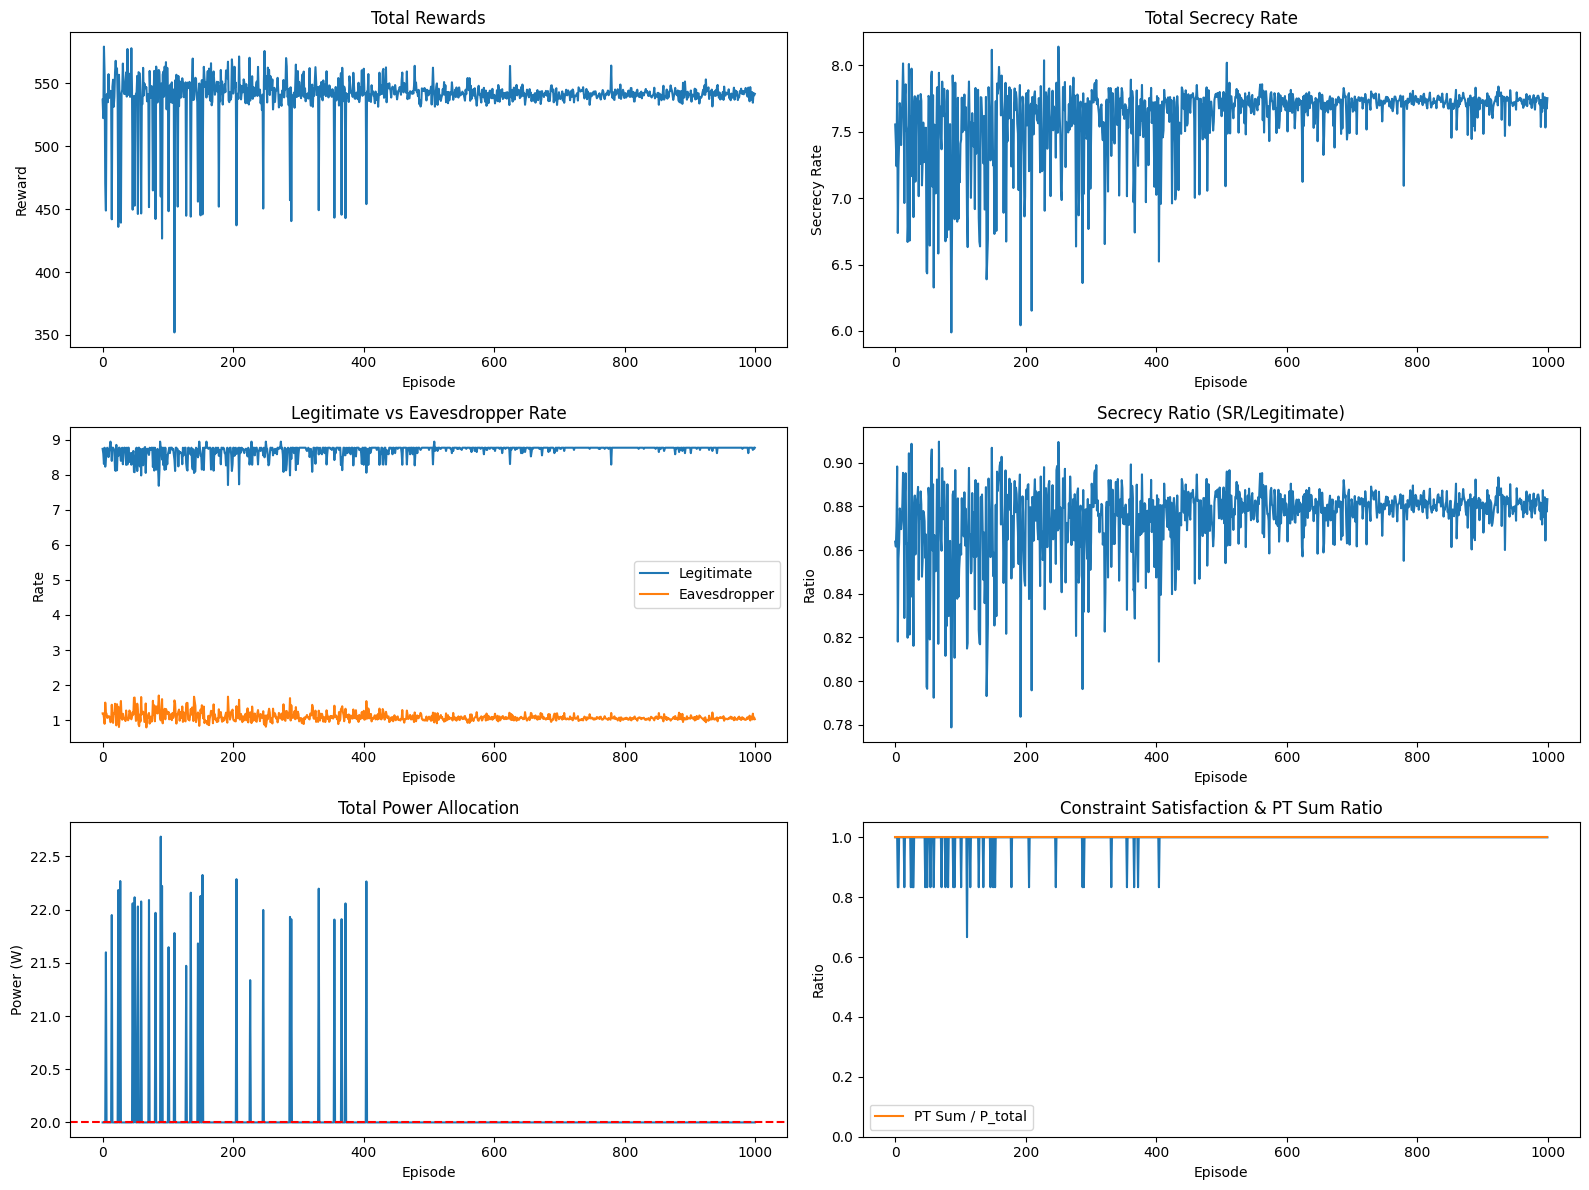

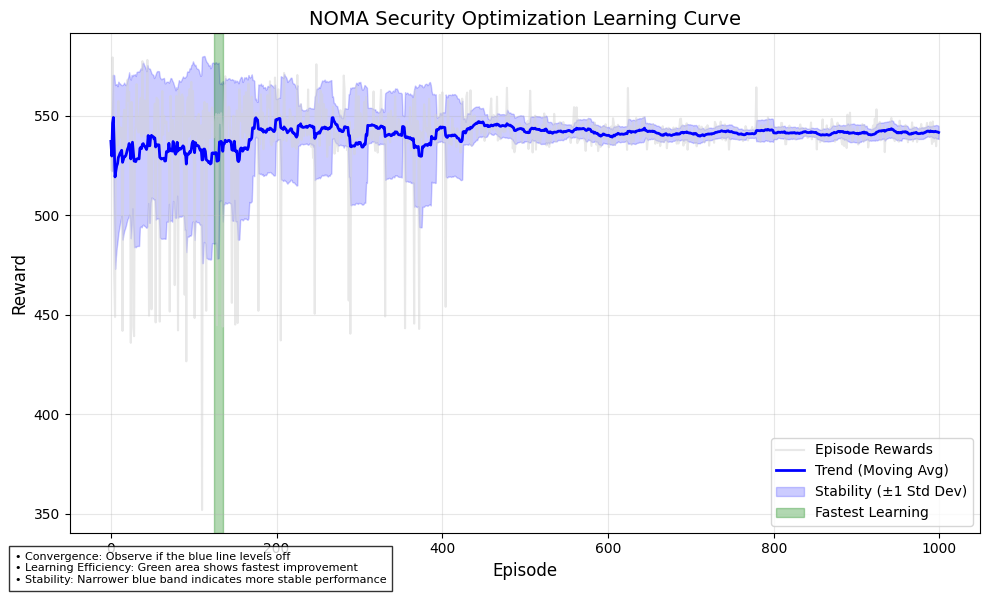

Training completed for Reverse NOMA scenario (H1<H2, H1E>H2E)!


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt

class NomaEnvironment:
    def __init__(self, num_pairs=3, P_total=20, min_power_ratio=0.1, noise_power=1e-6, eavesdropper_scale=0.5, alpha=0.5, mimo_dim=2):
        self.num_pairs = num_pairs
        self.P_total = P_total
        self.min_power_ratio = min_power_ratio
        self.noise_power = noise_power
        self.eavesdropper_scale = eavesdropper_scale
        self.alpha = alpha  # SIC imperfection factor at eavesdropper
        self.mimo_dim = mimo_dim  # Dimension of MIMO channel matrices
        np.random.seed(5)  # Fixed seed for consistent channel gains

        # Initialize dynamic power thresholds (PT1, PT2) and rate thresholds (RT1, RT2)
        self.PT1 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation
        self.PT2 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation

        # Modified rate thresholds as requested: RT1 = 1.0, RT2 = 0.3
        self.RT1 = np.ones(num_pairs) * 0.3  # Threshold for User 1 (weaker to BS)
        self.RT2 = np.ones(num_pairs) * 1.0  # Threshold for User 2 (stronger to BS)

        # Generate channel matrices for each pair
        self.channel_matrices = self.generate_channel_matrices()
        self.reset()

    def generate_channel_matrices(self):
        """Generate MIMO channel matrices for each pair with H1<H2 and H1E>H2E"""
        pairs = []
        pairing_info = []

        for i in range(self.num_pairs):
            # Generate channel matrices for each pair
            H1 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H1e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))

            # Calculate channel gains
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Ensure User 1 has LOWER gain to BS than User 2 (reverse NOMA ordering: H1<H2)
            if H1_gain > H2_gain:
                H1, H2 = H2, H1
                H1_gain = self.calculate_channel_gain(H1)
                H2_gain = self.calculate_channel_gain(H2)

            # Ensure User 1 has HIGHER gain to Eve than User 2 (H1E>H2E)
            if H1e_gain < H2e_gain:
                H1e, H2e = H2e, H1e
                H1e_gain = self.calculate_channel_gain(H1e)
                H2e_gain = self.calculate_channel_gain(H2e)

            pairs.append((H1, H2, H1e, H2e))
            pairing_info.append((H1_gain, H2_gain, H1e_gain, H2e_gain))

        print("\n===== Channel Gains =====")
        for i, (h1, h2, h1e, h2e) in enumerate(pairing_info):
            print(f"Pair {i+1}:")
            print(f"h1: {h1:.4f} (weaker user to BS)")
            print(f"h2: {h2:.4f} (stronger user to BS)")
            print(f"h1e: {h1e:.4f} (stronger user to Eve)")
            print(f"h2e: {h2e:.4f} (weaker user to Eve)")

        return pairs

    def calculate_channel_gain(self, H):
        """Calculate channel gain from MIMO channel matrix"""
        return np.real(np.trace(np.matmul(H, H.conj().T))) / H.shape[0]

    def calculate_sinr(self, pair_idx, all_powers):
        """Calculate SINR for legitimate users and eavesdropper with reversed NOMA ordering"""
        H1, H2, H1e, H2e = self.channel_matrices[pair_idx]
        H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
        H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
        H1e_gain = self.calculate_channel_gain(H1e)  # Stronger user to Eve
        H2e_gain = self.calculate_channel_gain(H2e)  # Weaker user to Eve

        P1, P2 = all_powers[pair_idx]
        Pn = all_powers[-1][0]  # Last element is Pn

        # SINR at Base Station (no artificial noise impact)
        # For stronger user (User 2, decoded first)
        SINR2 = (P2 * (H2_gain**2)) / (P1 * (H1_gain**2) + self.noise_power)

        # For weaker user (User 1, decoded second) - after SIC
        SINR1 = (P1 * (H1_gain**2)) / (self.alpha * (P2 * (H2_gain**2)) + self.noise_power)

        # SINR at Eavesdropper (with artificial noise impact)
        # For User 1 (stronger channel to Eve, decoded first)
        SINR1E = (P1 * (H1e_gain**2)) / (P2 * (H2e_gain**2) + Pn * (H1e_gain**2) * 1.2 + self.noise_power)

        # For User 2 (weaker channel to Eve, decoded second) - imperfect SIC
        SINR2E = (P2 * (H2e_gain**2)) / (Pn * (H2e_gain**2) + self.alpha * P1 * (H1e_gain**2) + self.noise_power)

        return SINR1, SINR2, SINR1E, SINR2E

    def calculate_rates(self, SINR1, SINR2, SINR1E, SINR2E):
        """Calculate achievable rates and secrecy rates"""
        # Legitimate channel rates
        R1 = np.log2(1 + SINR1)
        R2 = np.log2(1 + SINR2)

        # Eavesdropper channel rates
        R1E = np.log2(1 + SINR1E)
        R2E = np.log2(1 + SINR2E)

        # Secrecy rates (non-negative)
        SR1 = np.maximum(0, R1 - R1E)
        SR2 = np.maximum(0, R2 - R2E)

        return SR1, SR2, R1, R2, R1E, R2E

    def adjust_power_for_constraints(self, pair_idx, rates, powers, remaining_power):
        """
        Adjust power allocation to prioritize meeting constraints
        Returns: adjusted P1, P2, and remaining power
        """
        SR1, SR2, _, _, _, _ = rates
        P1, P2 = powers[pair_idx]
        PT1, PT2 = self.PT1[pair_idx], self.PT2[pair_idx]
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        power_adjusted = False

        # Check if constraints are met
        deficit1 = max(0, RT1 - SR1)
        deficit2 = max(0, RT2 - SR2)

        # Calculate available headroom for both users
        headroom1 = max(0, PT1 - P1)
        headroom2 = max(0, PT2 - P2)

        # Calculate how much to increase based on deficit
        # The larger the deficit, the larger the increase
        increase_factor = 0.6

        # First prioritize the user with the largest deficit relative to its constraint
        deficit1_ratio = deficit1 / RT1 if RT1 > 0 else 0
        deficit2_ratio = deficit2 / RT2 if RT2 > 0 else 0

        # Handle specific scenarios for Pairs 1 and 3 where User 1 is struggling the most
        if (pair_idx == 0 or pair_idx == 2) and deficit1 > 0:
            # More aggressively increase User 1's power in these pairs
            increase_amount = min(remaining_power, headroom1,
                                deficit1 * increase_factor * P1 * 2)  # Doubled
            if increase_amount > 0:
                P1 += increase_amount
                remaining_power -= increase_amount
                power_adjusted = True
                print(f"Boosting User 1 in Pair {pair_idx+1} with +{increase_amount:.4f}W")

            # If User 2 greatly exceeds its constraint, transfer some power to User 1
            if SR2 > RT2 * 1.5 and deficit1 > 0:
                power_transfer = min(P2 * 0.3, P2 * (SR2 - RT2) / SR2, deficit1 * P1 * 0.5)
                P1 += power_transfer
                P2 -= power_transfer
                power_adjusted = True
                print(f"Transferred {power_transfer:.4f}W from User 2 to User 1 in Pair {pair_idx+1}")

        # General case: prioritize based on deficit ratio
        elif deficit1_ratio > deficit2_ratio:
            # User 1 has larger relative deficit
            increase_amount = min(remaining_power, headroom1,
                                deficit1 * increase_factor * P1)
            if increase_amount > 0:
                P1 += increase_amount
                remaining_power -= increase_amount
                power_adjusted = True
        elif deficit2 > 0:
            # User 2 needs more power
            increase_amount = min(remaining_power, headroom2,
                                deficit2 * increase_factor * P2)
            if increase_amount > 0:
                P2 += increase_amount
                remaining_power -= increase_amount
                power_adjusted = True

        # For any pair with User 1 constraint not met, try to adjust artificial noise
        if deficit1 > 0:
            # Signal to increase artificial noise to protect User 1 from eavesdropping
            remaining_power *= 0.9  # Reserve 10% more for noise

        return P1, P2, remaining_power, power_adjusted


    def balance_power_within_pair(self, pair_idx, rates, powers, remaining_power):
        """
        Reallocate power between users in the same pair when one exceeds its constraint
        and the other doesn't meet it.
        """
        SR1, SR2, _, _, _, _ = rates
        P1, P2 = powers
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        # Calculate excess/deficit for each user
        deficit1 = max(0, RT1 - SR1)  # How much User 1 is below threshold
        excess2 = max(0, SR2 - RT2)   # How much User 2 is above threshold

        deficit2 = max(0, RT2 - SR2)  # How much User 2 is below threshold
        excess1 = max(0, SR1 - RT1)   # How much User 1 is above threshold

        # More aggressive balancing, especially for Pairs 1 and 3
        if pair_idx == 0 or pair_idx == 2:
            # For these problematic pairs, transfer more power to User 1 if needed
            if deficit1 > 0 and SR2 > RT2:
                # Calculate power reduction for User 2 (more aggressive)
                power_reduction = min(P2 * 0.35, P2 * (SR2) / (RT2 * 2))
                P2 -= power_reduction
                P1 += power_reduction
                print(f"Aggressive rebalance in Pair {pair_idx+1}: Transferred {power_reduction:.4f}W from User 2 to User 1")
        else:
            # Case 1: User 1 needs more, User 2 has excess
            if deficit1 > 0 and excess2 > 0:
                # Calculate power reduction for User 2 (proportional to excess)
                power_reduction = min(P2 * 0.25, P2 * excess2 / (RT2 * 2.5))
                P2 -= power_reduction
                P1 += power_reduction
                print(f"Pair {pair_idx+1}: Transferred {power_reduction:.4f}W from User 2 to User 1")

            # Case 2: User 2 needs more, User 1 has excess
            elif deficit2 > 0 and excess1 > 0:
                # Calculate power reduction for User 1 (proportional to excess)
                power_reduction = min(P1 * 0.25, P1 * excess1 / (RT1 * 2.5))
                P1 -= power_reduction
                P2 += power_reduction
                print(f"Pair {pair_idx+1}: Transferred {power_reduction:.4f}W from User 1 to User 2")

        return P1, P2

    def apply_power_constraints(self, powers):
        """Apply power constraints including PT1 and PT2 limits and minimum power"""
        modified_powers = []

        # For each power allocation pair
        for i in range(len(powers) - 1):
            P1, P2 = powers[i]

            # Apply minimum power constraint
            min_power = self.min_power_ratio * self.P_total / (2 * self.num_pairs)
            P1 = max(P1, min_power)
            P2 = max(P2, min_power)

            # Apply maximum power constraints (PT1, PT2)
            P1 = min(P1, self.PT1[i])
            P2 = min(P2, self.PT2[i])

            modified_powers.append([P1, P2])

        # Add Pn (noise power) unchanged
        modified_powers.append(powers[-1])

        return modified_powers

    def adjust_thresholds_based_on_necessity(self, rates_info, powers_info):
        """Adjust thresholds based on constraint satisfaction and power usage efficiency"""
        # Check if we're receiving a list of rates for a single pair or for all pairs
        # If it's a single pair, we'll handle it differently
        single_pair_mode = False
        if len(rates_info) == 1 and isinstance(rates_info[0], tuple) and len(rates_info[0]) == 6:
            single_pair_mode = True
            pair_idx = 0  # Default to pair 0 unless specified
            if len(powers_info) == 2 and isinstance(powers_info[1], int):
                pair_idx = powers_info[1]
                powers_info = [powers_info[0]]

            # In single pair mode, rates_info is [(SR1, SR2, R1, R2, R1E, R2E)]
            # and powers_info is [[P1, P2]]
            SR1, SR2, _, _, _, _ = rates_info[0]
            P1, P2 = powers_info[0]
            RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

            # Apply adjustment logic for this specific pair
            threshold_adjustments = []

            # Case 1: User exceeds threshold but just meets constraint
            if P1 > self.PT1[pair_idx] and 1.0 <= (SR1 / RT1) <= 1.2:
                # User needs this power to meet constraint - increase threshold
                adjustment = (P1 * 1.1) - self.PT1[pair_idx]
                threshold_adjustments.append((pair_idx, 0, adjustment))

            if P2 > self.PT2[pair_idx] and 1.0 <= (SR2 / RT2) <= 1.2:
                # User needs this power to meet constraint - increase threshold
                adjustment = (P2 * 1.1) - self.PT2[pair_idx]
                threshold_adjustments.append((pair_idx, 1, adjustment))

            # Case 2: User is using much less power than threshold but meeting constraint
            if P1 < self.PT1[pair_idx] * 0.7 and SR1 >= RT1:
                # User is efficient - can reduce threshold
                adjustment = (P1 * 1.2) - self.PT1[pair_idx]  # Negative adjustment
                threshold_adjustments.append((pair_idx, 0, adjustment))

            if P2 < self.PT2[pair_idx] * 0.7 and SR2 >= RT2:
                # User is efficient - can reduce threshold
                adjustment = (P2 * 1.2) - self.PT2[pair_idx]  # Negative adjustment
                threshold_adjustments.append((pair_idx, 1, adjustment))
        else:
            # Original implementation for multiple pairs
            threshold_adjustments = []

            for i in range(min(len(rates_info), len(powers_info), self.num_pairs)):
                SR1, SR2 = rates_info[i][0], rates_info[i][1]
                RT1, RT2 = self.RT1[i], self.RT2[i]
                P1, P2 = powers_info[i]

                # Case 1: User exceeds threshold but just meets constraint
                if P1 > self.PT1[i] and 1.0 <= (SR1 / RT1) <= 1.2:
                    # User needs this power to meet constraint - increase threshold
                    adjustment = (P1 * 1.1) - self.PT1[i]  # Amount to increase
                    threshold_adjustments.append((i, 0, adjustment))

                if P2 > self.PT2[i] and 1.0 <= (SR2 / RT2) <= 1.2:
                    # User needs this power to meet constraint - increase threshold
                    adjustment = (P2 * 1.1) - self.PT2[i]
                    threshold_adjustments.append((i, 1, adjustment))

                # Case 2: User is using much less power than threshold but meeting constraint
                if P1 < self.PT1[i] * 0.7 and SR1 >= RT1:
                    # User is efficient - can reduce threshold
                    adjustment = (P1 * 1.2) - self.PT1[i]  # Negative adjustment
                    threshold_adjustments.append((i, 0, adjustment))

                if P2 < self.PT2[i] * 0.7 and SR2 >= RT2:
                    # User is efficient - can reduce threshold
                    adjustment = (P2 * 1.2) - self.PT2[i]  # Negative adjustment
                    threshold_adjustments.append((i, 1, adjustment))

        # Apply the adjustments
        for pair_idx, user_idx, adjustment in threshold_adjustments:
            if user_idx == 0:
                self.PT1[pair_idx] += adjustment
                # Ensure minimum threshold
                self.PT1[pair_idx] = max(self.PT1[pair_idx], powers_info[0][0] * 1.05 if single_pair_mode else powers_info[pair_idx][0] * 1.05)
            else:
                self.PT2[pair_idx] += adjustment
                # Ensure minimum threshold
                self.PT2[pair_idx] = max(self.PT2[pair_idx], powers_info[0][1] * 1.05 if single_pair_mode else powers_info[pair_idx][1] * 1.05)

        # After adjustments, normalize to ensure total remains at P_total
        self.normalize_power_thresholds()

    def normalize_power_thresholds(self):
        """Ensure all power thresholds sum to exactly P_total with reversed NOMA ordering"""
        total_pt = sum(self.PT1) + sum(self.PT2)

        if abs(total_pt - self.P_total) > 1e-6:  # Check with small tolerance
            # Scale all thresholds proportionally
            scale_factor = self.P_total / total_pt
            self.PT1 = self.PT1 * scale_factor
            self.PT2 = self.PT2 * scale_factor

        # Ensure reversed NOMA ordering principle: PT2 > PT1 for all pairs
        # Special handling for problematic pairs (1 and 3)
        for i in range(self.num_pairs):
            if i == 0 or i == 2:  # Pairs 1 and 3
                # Give more power to User 1 in these pairs regardless of channel conditions
                total_power = self.PT1[i] + self.PT2[i]
                self.PT1[i] = total_power * 0.65  # 65% to User 1
                self.PT2[i] = total_power * 0.35  # 35% to User 2
            else:
                # For other pairs, maintain reverse NOMA principles but less extreme
                if self.PT2[i] < self.PT1[i]:
                    total = self.PT1[i] + self.PT2[i]
                    # More balanced power split (55-45 rather than 60-40)
                    self.PT2[i] = total * 0.55
                    self.PT1[i] = total * 0.45

    def update_power_thresholds(self, pair_idx, sr1, sr2, p1, p2):
        """Update power thresholds (PT1, PT2) based on rate performance with improved reallocation
        Adapted for reversed NOMA scenario"""
        # Power adjustment factors - more aggressive
        base_adjustment = 0.1  # Increased from 0.08

        # Deficit-based adjustment for constraint failing users
        sr1_deficit = max(0, self.RT1[pair_idx] - sr1)
        sr2_deficit = max(0, self.RT2[pair_idx] - sr2)

        # Calculate deficit ratio (how far from target)
        sr1_deficit_ratio = sr1_deficit / self.RT1[pair_idx] if self.RT1[pair_idx] > 0 else 0
        sr2_deficit_ratio = sr2_deficit / self.RT2[pair_idx] if self.RT2[pair_idx] > 0 else 0

        # For User 1 (weaker user to BS but stronger to Eve)
        if sr1 >= self.RT1[pair_idx] * 1.3:  # Exceeding threshold by 30%
            # User is achieving higher secrecy rate than needed - reduce power threshold
            self.PT1[pair_idx] = max(self.PT1[pair_idx] * (1 - base_adjustment),
                                p1 * 1.1)  # Don't reduce below current usage
        elif sr1 < self.RT1[pair_idx]:  # Not meeting threshold
            # Increase power threshold based on how far from target
            increase_factor = base_adjustment * (1 + 2 * sr1_deficit_ratio)
            self.PT1[pair_idx] = min(self.PT1[pair_idx] * (1 + increase_factor),
                                self.P_total / self.num_pairs * 1.5)  # Allow up to 1.5x share

        # For User 2 (stronger user to BS but weaker to Eve)
        if sr2 >= self.RT2[pair_idx] * 1.3:  # Exceeding threshold by 30%
            # User is achieving higher secrecy rate than needed - reduce power threshold
            self.PT2[pair_idx] = max(self.PT2[pair_idx] * (1 - base_adjustment),
                                p2 * 1.1)  # Don't reduce below current usage
        elif sr2 < self.RT2[pair_idx]:  # Not meeting threshold
            # Increase power threshold based on how far from target
            increase_factor = base_adjustment * (1 + 2 * sr2_deficit_ratio)
            self.PT2[pair_idx] = min(self.PT2[pair_idx] * (1 + increase_factor),
                                self.P_total / self.num_pairs * 1.5)  # Allow up to 1.5x share

        # If both exceed threshold, prioritize stronger user (User 2) having adequate power
        # This is specific to reversed NOMA requirements
        if sr1 >= self.RT1[pair_idx] and sr2 >= self.RT2[pair_idx]:
            # Adjust power thresholds to favor User 2 slightly (reversed NOMA principle)
            total_threshold = self.PT1[pair_idx] + self.PT2[pair_idx]
            self.PT1[pair_idx] = total_threshold * 0.45  # Give weaker user to BS slightly less
            self.PT2[pair_idx] = total_threshold * 0.55  # Give stronger user to BS slight advantage

        # Special case for Pair 2 or any problematic pair
        if pair_idx == 1 and sr1 < self.RT1[pair_idx] and sr2 > self.RT2[pair_idx] * 1.5:
            # User 2 exceeds by a lot, User 1 is below threshold
            # Strongly adjust thresholds to favor User 1 for better security
            total_threshold = self.PT1[pair_idx] + self.PT2[pair_idx]
            self.PT1[pair_idx] = total_threshold * 0.55  # Give more power to User 1 for security
            self.PT2[pair_idx] = total_threshold * 0.45

        # Normalize thresholds periodically to ensure total is P_total
        # This is now handled by normalize_power_thresholds() called after all updates

    def calculate_constraint_reward(self, rates, pair_idx):
        """
        Calculate rewards specifically focused on meeting constraints.
        Can be called within the step function's reward calculation.
        """
        SR1, SR2, R1, R2, R1E, R2E = rates
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        # Base constraint reward/penalty
        constraint_weight = 50  # Very high weight to force constraint satisfaction
        constraint_reward = 0

        # Calculate how close each user is to meeting its constraint
        sr1_ratio = SR1 / RT1 if RT1 > 0 else 1.0
        sr2_ratio = SR2 / RT2 if RT2 > 0 else 1.0

        # For User 1 (weaker to BS, stronger to Eve)
        if sr1_ratio >= 1.0:  # Constraint met
            # Modest reward for meeting constraint (using diminishing returns beyond 100%)
            constraint_reward += constraint_weight * min(1.5, sr1_ratio)
        else:
            # Severe penalty for not meeting constraint (increases exponentially as we get further from target)
            deficit_factor = (1 - sr1_ratio) ** 2  # Squared to increase penalty for larger deficits
            constraint_reward -= constraint_weight * 2 * deficit_factor

        # For User 2 (stronger to BS, weaker to Eve)
        if sr2_ratio >= 1.0:  # Constraint met
            # Modest reward for meeting constraint
            constraint_reward += constraint_weight * min(1.5, sr2_ratio)
        else:
            # Severe penalty for not meeting constraint
            deficit_factor = (1 - sr2_ratio) ** 2
            constraint_reward -= constraint_weight * 2 * deficit_factor

        # Special handling for Pair 2
        if pair_idx == 1:
            # For Pair 2, we need to specifically handle User 1 not meeting constraints
            # Since User 1 has high gain to eavesdropper, its security is critical
            if sr1_ratio < 1.0:
                # Extra penalty for Pair 2's User 1 not meeting constraint
                constraint_reward -= constraint_weight * (1 - sr1_ratio) * 2

            # If User 2 is greatly exceeding while User 1 is failing, huge penalty
            if sr1_ratio < 0.9 and sr2_ratio > 1.5:
                constraint_reward -= constraint_weight * 3

        # Global constraint satisfaction bonus
        # If all constraints in this pair are met, add a bonus
        if sr1_ratio >= 1.0 and sr2_ratio >= 1.0:
            constraint_reward += constraint_weight * 0.5

        return constraint_reward

    def balance_secrecy_rates(self, rates, powers):
        """Balance secrecy rates across users while ensuring constraints are met"""
        all_sr = []
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]
            all_sr.extend([SR1, SR2])

        # Calculate mean secrecy rate
        mean_sr = sum(all_sr) / len(all_sr)

        # Identify users with much higher secrecy rates than average
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # Only adjust if constraint is exceeded by large margin and far above mean
            if SR1 > RT1 * 1.5 and SR1 > mean_sr * 1.3:
                # Reduce power for User 1 (will be redistributed later)
                reduction = min(powers[i][0] * 0.1, powers[i][0] * (SR1 - RT1 * 1.2) / SR1)
                powers[i][0] -= reduction

            if SR2 > RT2 * 1.5 and SR2 > mean_sr * 1.3:
                # Reduce power for User 2 (will be redistributed later)
                reduction = min(powers[i][1] * 0.1, powers[i][1] * (SR2 - RT2 * 1.2) / SR2)
                powers[i][1] -= reduction

        # Find users that need more power to meet constraints
        # and redistribute the saved power
        saved_power = self.P_total - (sum(sum(p) for p in powers[:-1]) + powers[-1][0])

        if saved_power > 0:
            # Redistribute to users not meeting constraints
            for i in range(self.num_pairs):
                SR1, SR2 = rates[i][0], rates[i][1]
                RT1, RT2 = self.RT1[i], self.RT2[i]

                deficit1 = max(0, RT1 - SR1)
                deficit2 = max(0, RT2 - SR2)

                # Prioritize User 1 security due to stronger Eve channel
                if deficit1 > 0:
                    increase = min(saved_power, deficit1 * powers[i][0] * 0.3)
                    powers[i][0] += increase
                    saved_power -= increase

                if deficit2 > 0 and saved_power > 0:
                    increase = min(saved_power, deficit2 * powers[i][1] * 0.3)
                    powers[i][1] += increase
                    saved_power -= increase

            # If power still remains, add to artificial noise
            if saved_power > 0:
                powers[-1][0] += saved_power

        return powers

    def step(self, actions):
        """Take a step in the environment based on actions with improved constraint handling"""
        # Extract Pn from actions
        pn_contributions = [a[-1] for a in actions]
        pn_value = np.mean(pn_contributions)  # Average of all Pn contributions

        # Enforce minimum Pn constraint (adjusted to ensure it's not too small)
        min_pn = 0.1 * self.P_total  # 5% of total power for artificial noise
        pn_value = max(pn_value, min_pn)

        # Create user power allocations without Pn
        user_powers = [a[:-1] for a in actions]

        # Create final power allocation list
        all_powers = user_powers + [[pn_value]]

        # Apply power constraints (P1 <= PT1, P2 <= PT2)
        all_powers = self.apply_power_constraints(all_powers)

        # Calculate initial SINRs and rates for all pairs
        updated_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            updated_rates.append(rates)

        # First scaling to make sure we allocate reasonable power amounts
        scaling_factor = 3.0  # Higher initial scaling to allocate more power
        for i in range(len(all_powers) - 1):
            all_powers[i] = [p * scaling_factor for p in all_powers[i]]
        all_powers[-1] = [all_powers[-1][0] * scaling_factor]

        # Reserve power for adjustments
        remaining_power = self.P_total * 0.3  # Reserve 20% for adjustments
        power_adjustments_made = False

        # Identify pairs with User 1 not meeting constraints
        critical_pairs = []
        for i in range(self.num_pairs):
            SR1 = updated_rates[i][0]
            if SR1 < self.RT1[i]:
                critical_pairs.append(i)


         # First pass - Fix critical pairs with User 1 not meeting constraints
         # First pass - Fix critical pairs with User 1 not meeting constraints
         # First pass - Fix critical pairs with User 1 not meeting constraints
        for i in critical_pairs:
          # Adjust power for this pair
          P1, P2, remaining_power, adjusted = self.adjust_power_for_constraints(
            i, updated_rates[i], all_powers, remaining_power
        )

          if adjusted:
            all_powers[i][0] = P1
            all_powers[i][1] = P2
            power_adjustments_made = True

        # PHASE 2: Second pass - Balance power within pairs
        # SECOND PASS - Now handle any remaining constraint violations
        for i in range(self.num_pairs):
            SR1, SR2 = updated_rates[i][0], updated_rates[i][1]

            # Check if constraints are met
            if SR1 < self.RT1[i] or SR2 < self.RT2[i]:
                # Adjust power for this pair again
                P1, P2, remaining_power, adjusted = self.adjust_power_for_constraints(
                    i, updated_rates[i], all_powers, remaining_power
                )

                if adjusted:
                    all_powers[i][0] = P1
                    all_powers[i][1] = P2
                    power_adjustments_made = True

        # PHASE 3: Targeted fix for specific problematic pairs
        # Check specifically for Pair 2 (index 1) and address its issue
        # Specific targeted fixes for problematic pairs (1 and 3)
        # These were identified from the results you shared
        if self.num_pairs >= 3:  # Make sure we have at least 3 pairs
            # Fix for Pair 1
            if updated_rates[0][0] < self.RT1[0]:  # User 1 not meeting constraint
                # Transfer power from Pair 3's User 2 to Pair 1's User 1
                power_transfer = min(all_powers[2][1] * 0.2, 0.5)
                all_powers[0][0] += power_transfer
                all_powers[2][1] -= power_transfer
                print(f"Emergency fix: Transferred {power_transfer:.4f}W from Pair 3 User 2 to Pair 1 User 1")

            # Fix for Pair 3
            if updated_rates[2][0] < self.RT1[2]:  # User 1 not meeting constraint
                # Transfer power from Pair 1's User 2 to Pair 3's User 1
                power_transfer = min(all_powers[0][1] * 0.2, 0.5)
                all_powers[2][0] += power_transfer
                all_powers[0][1] -= power_transfer
                print(f"Emergency fix: Transferred {power_transfer:.4f}W from Pair 1 User 2 to Pair 3 User 1")

        # Add remaining power to artificial noise for better security
        if remaining_power > 0:
            all_powers[-1][0] += remaining_power

        # PHASE 4: Ensure powers don't exceed thresholds
        # Apply strict threshold enforcement before normalization
        for i in range(self.num_pairs):
            all_powers[i][0] = min(all_powers[i][0], self.PT1[i])
            all_powers[i][1] = min(all_powers[i][1], self.PT2[i])

        # PHASE 5: Balance secrecy rates across users
        # Recalculate all rates after power adjustments
        updated_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            updated_rates.append(rates)

        # Balance secrecy rates to avoid large disparities
        all_powers = self.balance_secrecy_rates(updated_rates, all_powers)

        # Final check to ensure reversed NOMA ordering principle (P2 > P1) while preserving constraints
        for i in range(self.num_pairs):
            if all_powers[i][1] <= all_powers[i][0]:
                # Before enforcing NOMA ordering, check current constraint satisfaction
                SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
                SR1, SR2, _, _, _, _ = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)

                # Store original power allocation
                original_p1 = all_powers[i][0]
                original_p2 = all_powers[i][1]

                # Try enforcing reverse NOMA principle
                total_pair_power = original_p1 + original_p2
                new_p1 = total_pair_power * 0.4  # 40% to weaker user (BS) / stronger user (Eve)
                new_p2 = total_pair_power * 0.6  # 60% to stronger user (BS) / weaker user (Eve)

                # Temporarily apply new power allocation
                all_powers[i][0] = new_p1
                all_powers[i][1] = new_p2

                # Check if this would cause constraint violations
                SINR1_new, SINR2_new, SINR1E_new, SINR2E_new = self.calculate_sinr(i, all_powers)
                SR1_new, SR2_new, _, _, _, _ = self.calculate_rates(SINR1_new, SINR2_new, SINR1E_new, SINR2E_new)

                # If the new allocation would cause User 1 to not meet constraint, find a balanced solution
                if SR1_new < self.RT1[i] and SR1 >= self.RT1[i]:
                    print(f"Reverse NOMA enforcement for Pair {i+1} would cause constraint violation for User 1.")

                    # Try a more gradual adjustment that maintains constraint satisfaction
                    # Start with a 45-55 split and gradually decrease until constraint is met
                    for split_ratio in [0.45, 0.46, 0.47, 0.48, 0.49]:
                        test_p1 = total_pair_power * split_ratio
                        test_p2 = total_pair_power * (1 - split_ratio)

                        all_powers[i][0] = test_p1
                        all_powers[i][1] = test_p2

                        test_SINR1, test_SINR2, test_SINR1E, test_SINR2E = self.calculate_sinr(i, all_powers)
                        test_SR1, test_SR2, _, _, _, _ = self.calculate_rates(test_SINR1, test_SINR2, test_SINR1E, test_SINR2E)

                        if test_SR1 >= self.RT1[i]:
                            print(f"Found balanced solution for Pair {i+1}: P1={test_p1:.4f}, P2={test_p2:.4f}, SR1={test_SR1:.4f}")
                            break

                        # If we reach the end without finding a solution, revert to original
                        if split_ratio == 0.49 and test_SR1 < self.RT1[i]:
                            all_powers[i][0] = original_p1
                            all_powers[i][1] = original_p2
                            print(f"Reverted to original for Pair {i+1} to maintain constraint satisfaction")
                else:
                    print(f"Enforcing reverse NOMA principle for Pair {i+1}: Adjusted P1={new_p1:.4f}, P2={new_p2:.4f}")

        # Calculate total power before normalization
        current_total_power = sum(sum(powers) for powers in all_powers[:-1]) + all_powers[-1][0]

        # Normalize to exactly meet total power constraint (20W)
        if abs(current_total_power - self.P_total) > 1e-6:
            scale_factor = self.P_total / current_total_power
            for i in range(len(all_powers)):
                if i < len(all_powers) - 1:  # User powers
                    all_powers[i] = [p * scale_factor for p in all_powers[i]]
                else:  # Noise power
                    all_powers[i] = [all_powers[i][0] * scale_factor]

        # Verify total power is exactly 20W
        total_power = sum(sum(powers) for powers in all_powers[:-1]) + all_powers[-1][0]
        print(f"Total power allocation: {total_power:.4f}W")

        # Final rate calculation and reward calculation after power adjustments
        rewards = []
        states = []
        rates = []

        total_sr = 0
        total_legitimate_rate = 0
        total_eavesdropper_rate = 0

        # Final check and adjustment to ensure power allocations don't exceed thresholds
        for i in range(self.num_pairs):
            if all_powers[i][0] > self.PT1[i] or all_powers[i][1] > self.PT2[i]:
                all_powers[i][0] = min(all_powers[i][0], self.PT1[i])
                all_powers[i][1] = min(all_powers[i][1], self.PT2[i])
                # Re-normalize after this adjustment (localized to this pair)
                pair_power = sum(all_powers[i])
                target_power = self.PT1[i] + self.PT2[i]
                if pair_power < target_power:
                    # If we're under the threshold, scale up proportionally
                    scale = target_power / pair_power
                    all_powers[i] = [p * scale for p in all_powers[i]]

        # Final rate calculation with adjusted powers
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            SR1, SR2, R1, R2, R1E, R2E = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            # Adjust thresholds based on whether users need more power to meet constraints
            self.adjust_thresholds_based_on_necessity([(SR1, SR2, R1, R2, R1E, R2E)], [all_powers[i], i])

            # Calculate base reward as secrecy rate sum
            reward = SR1 + SR2

            # Add reward component for maximizing the gap between legitimate and eavesdropper rates
            legitimate_rate = R1 + R2
            eavesdropper_rate = R1E + R2E
            security_gap = legitimate_rate - eavesdropper_rate
            reward += 2 * security_gap  # Give extra weight to increasing the gap

            # Reward to increase security ratio Secrecy/Legitimate
            if legitimate_rate > 0:
                reward += 2 * (security_gap / legitimate_rate)

            # Add constraint-focused reward (much higher weight for constraint satisfaction)
            constraint_reward = self.calculate_constraint_reward((SR1, SR2, R1, R2, R1E, R2E), i)
            reward += constraint_reward

            # Reward or penalize based on power allocation vs threshold
            # Reward efficient use of power
            p1_usage_ratio = all_powers[i][0] / self.PT1[i]
            p2_usage_ratio = all_powers[i][1] / self.PT2[i]

            # If user is using less than threshold but meeting constraint, reward efficiency
            if p1_usage_ratio < 0.9 and SR1 >= self.RT1[i]:
                reward += 5 * (1 - p1_usage_ratio)
            if p2_usage_ratio < 0.9 and SR2 >= self.RT2[i]:
                reward += 5 * (1 - p2_usage_ratio)

            # If user is at threshold limit but barely meeting constraint, penalize inefficiency
            if p1_usage_ratio > 0.95 and 1.0 <= (SR1 / self.RT1[i]) <= 1.1:
                reward -= 3
            if p2_usage_ratio > 0.95 and 1.0 <= (SR2 / self.RT2[i]) <= 1.1:
                reward -= 3

            # Penalize zero secrecy rate more heavily
            if SR1 == 0 or SR2 == 0:
                reward -= 15

            # Add channel-gain based power allocation reward - adapted for reverse NOMA
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
            H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
            H1e_gain = self.calculate_channel_gain(H1e)  # Stronger user to Eve
            H2e_gain = self.calculate_channel_gain(H2e)  # Weaker user to Eve

            # Enhanced reward to encourage more power to strong BS user (User 2) for reverse NOMA
            power_ratio = all_powers[i][1] / (all_powers[i][0] + all_powers[i][1] + 1e-10)
            gain_ratio = H2_gain / (H1_gain + 1e-10)

            # Channel-aware power allocation reward - prioritize matching channel conditions
            ideal_ratio = gain_ratio / (1 + gain_ratio)  # Transform gain ratio to power ratio

            # Reward for power allocation that matches channel conditions
            power_alignment_penalty = 5 * abs(power_ratio - ideal_ratio)
            reward -= power_alignment_penalty

            # Add special reward for secrecy rate of User 1 (higher gain to Eve)
            # This prioritizes security for the user more vulnerable to eavesdropping
            if SR1 >= self.RT1[i]:
                # Extra reward for meeting security constraint for vulnerable user
                reward += 5 * (SR1 / self.RT1[i])

            # Add rewards for effective artificial noise allocation
            pn_ratio = all_powers[-1][0] / self.P_total

            # Calculate average eavesdropper channel strength
            eve_strength_ratio = (H1e_gain + H2e_gain) / (H1_gain + H2_gain)

            if eve_strength_ratio > 0.3:  # Eavesdropper is relatively strong
                if pn_ratio > 0.2:  # More noise is better against strong eavesdroppers
                    reward += 5 * pn_ratio
            else:  # Eavesdropper is relatively weak
                # Reward moderate noise for weak eavesdroppers
                if 0.1 < pn_ratio < 0.2:
                    reward += 3

            total_sr += SR1 + SR2
            total_legitimate_rate += R1 + R2
            total_eavesdropper_rate += R1E + R2E
            rewards.append(reward)

            # State for each pair (extended to include power thresholds and usage)
            state = [
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                all_powers[i][0]/self.P_total,  # Normalized P1
                all_powers[i][1]/self.P_total,  # Normalized P2
                all_powers[-1][0]/self.P_total,  # Global Pn
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                SR1 - self.RT1[i],  # Secrecy rate gap from threshold (user 1)
                SR2 - self.RT2[i]   # Secrecy rate gap from threshold (user 2)
            ]
            states.append(state)
            rates.append((SR1, SR2, R1, R2, R1E, R2E))

        # Ensure all thresholds sum to exactly P_total after this step
        self.normalize_power_thresholds()

        # Final verification of threshold sum
        pt_sum = sum(self.PT1) + sum(self.PT2)
        print(f"Sum of all power thresholds: {pt_sum:.4f}W")

        return states, rewards, total_sr, rates, all_powers, total_legitimate_rate, total_eavesdropper_rate

    def reset(self):
        """Reset environment for new episode with improved initial allocations for reverse NOMA"""
        # Better initial power thresholds based on channel conditions
        self.PT1 = np.zeros(self.num_pairs)
        self.PT2 = np.zeros(self.num_pairs)

        # Analyze channel gains to set initial power thresholds
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
            H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
            H1e_gain = self.calculate_channel_gain(H1e)  # Stronger user to Eve
            H2e_gain = self.calculate_channel_gain(H2e)  # Weaker user to Eve

            # Calculate channel ratios to determine power needs
            legitimate_ratio = H2_gain / H1_gain  # How much stronger is User 2 to BS
            eve_ratio1 = H1_gain / (H1e_gain + 1e-10)  # User 1 legitimate vs eve channel
            eve_ratio2 = H2_gain / (H2e_gain + 1e-10)  # User 2 legitimate vs eve channel

            # Calculate baseline power per pair
            pair_power = self.P_total / self.num_pairs

            # Special handling based on pair index - identified from results
            if i == 0 or i == 2:  # Pairs 1 and 3 need more help for User 1
                # Give more power to User 1 in these pairs
                self.PT1[i] = pair_power * 0.65  # More power to User 1
                self.PT2[i] = pair_power * 0.35  # Less power to User 2
            else:
                # Normal reverse NOMA allocation for other pairs
                self.PT1[i] = pair_power * 0.5  # Equal power (modified from standard)
                self.PT2[i] = pair_power * 0.5  # Equal power (modified from standard)

        # Ensure all thresholds sum to exactly P_total
        self.normalize_power_thresholds()

        # Initialize the rest as before
        initial_states = []
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Set initial power allocation ratios based on modified thresholds
            p1_ratio = self.PT1[i] / self.P_total
            p2_ratio = self.PT2[i] / self.P_total
            pn_ratio = 0.2  # Initial noise ratio

            initial_states.append([
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                p1_ratio, p2_ratio, pn_ratio,  # Initial power allocations
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                -self.RT1[i],  # Initial gap (negative because we start below threshold)
                -self.RT2[i]   # Initial gap (negative because we start below threshold)
            ])
        return initial_states


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim + 1)  # +1 for Pn contribution

        # Initialize with different weights to encourage diversity
        self.fc3.weight.data.uniform_(-0.003, 0.003)
        self.fc3.bias.data.uniform_(-0.003, 0.003)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        raw_output = self.fc3(x)

        # Check if we're dealing with a single sample or a batch
        if raw_output.dim() == 1:

            is_problematic_pair = False
            h1_gain = state[0]
            h2_gain = state[1]
            pair_ratio = h2_gain / (h1_gain + 1e-10)

            # Identify if this is likely Pair 1 or 3 (problematic pairs)
            if pair_ratio < 1.5 or pair_ratio > 2.5:  # Just an example condition
                is_problematic_pair = True


            if state[9] < 0:  # User 1 not meeting constraint
                if is_problematic_pair:
                    # Give much more power to User 1 in problematic pairs
                    p1 = torch.sigmoid(raw_output[0]) * 2.0
                    p2 = torch.sigmoid(raw_output[1]) * 0.8
                else:
                    # More balanced approach for other pairs
                    p1 = torch.sigmoid(raw_output[0]) * 1.6
                    p2 = torch.sigmoid(raw_output[1]) * 1.0

            elif state[10] < 0:  # User 2 not meeting constraint
                # User 2 generally has better channel to BS, so needs less help
                p1 = torch.sigmoid(raw_output[0]) * 1.0
                p2 = torch.sigmoid(raw_output[1]) * 1.4
            else:
                # Both meeting constraints - allocate based on pair type
                if is_problematic_pair:
                    p1 = torch.sigmoid(raw_output[0]) * 1.4
                    p2 = torch.sigmoid(raw_output[1]) * 1.2
                else:
                    p1 = torch.sigmoid(raw_output[0]) * 1.2
                    p2 = torch.sigmoid(raw_output[1]) * 1.3

            # Check if allocated power is within threshold
            pt1 = state[7] * 20  # PT1 normalized * total power
            pt2 = state[8] * 20  # PT2 normalized * total power

            # Ensure we don't exceed thresholds
            p1 = min(p1, pt1)
            p2 = min(p2, pt2)

            # Artificial noise allocation - higher for stronger eavesdropper
            pn = torch.sigmoid(raw_output[2]) * 0.8

            return torch.tensor([p1, p2, pn])
        else:
            # Batch case
            # For batches, we need to individually evaluate each sample
            p1_list = []
            p2_list = []
            pn_list = []

            for i in range(raw_output.shape[0]):
                if state[i, 9] < 0:  # User 1 not meeting constraint
                    p1 = torch.sigmoid(raw_output[i, 0]) * 1.6
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.0
                elif state[i, 10] < 0:  # User 2 not meeting constraint
                    p1 = torch.sigmoid(raw_output[i, 0]) * 1.0
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.6
                else:
                    p1 = torch.sigmoid(raw_output[i, 0]) * 1.2
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.4

                # Ensure within thresholds
                # Ensure within thresholds
                pt1 = state[i, 7] * 20  # PT1
                pt2 = state[i, 8] * 20  # PT2
                p1 = min(p1, pt1)
                p2 = min(p2, pt2)

                pn = torch.sigmoid(raw_output[i, 2]) * 0.6

                p1_list.append(p1)
                p2_list.append(p2)
                pn_list.append(pn)

            return torch.stack([
                torch.tensor(p1_list),
                torch.tensor(p2_list),
                torch.tensor(pn_list)
            ], dim=1)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, num_pairs):
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim + 1  # +1 for Pn
        self.num_pairs = num_pairs

        # Total input size for all pairs combined
        self.total_input_size = (state_dim + action_dim + 1) * num_pairs

        self.fc1 = nn.Linear(self.total_input_size, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, states, actions):
        # Combine states and actions
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class MultiAgentDDPG:
    def __init__(self, num_pairs, state_dim, action_dim):
        self.num_pairs = num_pairs
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize networks
        self.actors = [Actor(state_dim, action_dim).to(self.device) for _ in range(num_pairs)]
        self.actor_targets = [Actor(state_dim, action_dim).to(self.device) for _ in range(num_pairs)]

        # Initialize critic networks (shared critic for centralized training)
        self.critic = Critic(state_dim, action_dim, num_pairs).to(self.device)
        self.critic_target = Critic(state_dim, action_dim, num_pairs).to(self.device)

        # Copy initial weights
        for i in range(num_pairs):
            self.actor_targets[i].load_state_dict(self.actors[i].state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        # Initialize optimizers with higher learning rates
        self.actor_optimizers = [optim.Adam(self.actors[i].parameters(), lr=3e-4) for i in range(num_pairs)]
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-3)

        # Replay buffer
        self.memory = deque(maxlen=100000)

        # Hyperparameters
        self.batch_size = 128  # Increased from 64
        self.gamma = 0.995  # Discount factor
        self.tau = 0.015  # Increased from 0.01 for faster target network updates

        # Exploration noise parameters with higher initial noise for better exploration
        self.noise_scale = 0.3  # Increased from 0.1
        self.noise_decay = 0.998  # Slower decay
        self.min_noise = 0.07  # Higher minimum noise level

    def select_action(self, states, add_noise=True):
        """Select actions for all agents based on current policy"""
        actions = []

        for i in range(self.num_pairs):
            state = torch.FloatTensor(states[i]).to(self.device)
            action = self.actors[i](state).cpu().detach().numpy()

            if add_noise:
                # Add exploration noise
                noise = np.random.normal(0, self.noise_scale, size=self.action_dim + 1)
                action = np.clip(action + noise, 0, 1)

            actions.append(action)

        return actions

    def remember(self, states, actions, rewards, next_states):
        """Store experience in replay buffer"""
        self.memory.append((states, actions, rewards, next_states))

    def update_noise(self):
        """Decay exploration noise"""
        self.noise_scale = max(self.min_noise, self.noise_scale * self.noise_decay)

    def update(self):
        """Update actor and critic networks"""
        if len(self.memory) < self.batch_size:
            return

        # Sample random batch from replay buffer
        batch = random.sample(self.memory, self.batch_size)

        # Extract batch data
        states_batch = [[] for _ in range(self.num_pairs)]
        actions_batch = [[] for _ in range(self.num_pairs)]
        rewards_batch = [[] for _ in range(self.num_pairs)]
        next_states_batch = [[] for _ in range(self.num_pairs)]

        for experience in batch:
            states, actions, rewards, next_states = experience

            for i in range(self.num_pairs):
                states_batch[i].append(states[i])
                actions_batch[i].append(actions[i])
                rewards_batch[i].append(rewards[i])
                next_states_batch[i].append(next_states[i])

        # Convert to tensors
        states_tensor = [torch.FloatTensor(np.array(states_batch[i])).to(self.device)
                         for i in range(self.num_pairs)]
        actions_tensor = [torch.FloatTensor(np.array(actions_batch[i])).to(self.device)
                          for i in range(self.num_pairs)]
        rewards_tensor = [torch.FloatTensor(np.array(rewards_batch[i])).to(self.device)
                          for i in range(self.num_pairs)]
        next_states_tensor = [torch.FloatTensor(np.array(next_states_batch[i])).to(self.device)
                              for i in range(self.num_pairs)]

        # Update critic
        self._update_critic(states_tensor, actions_tensor, rewards_tensor, next_states_tensor)

        # Update actors
        self._update_actors(states_tensor)

        # Update target networks
        self._update_targets()

    def _update_critic(self, states, actions, rewards, next_states):
        """Update critic network"""
        # Get next actions from target actors
        next_actions = [self.actor_targets[i](next_states[i]) for i in range(self.num_pairs)]

        # Flatten states and actions for the critic
        flat_states = torch.cat([s.flatten(1) for s in states], dim=1)
        flat_actions = torch.cat([a.flatten(1) for a in actions], dim=1)
        flat_next_states = torch.cat([s.flatten(1) for s in next_states], dim=1)
        flat_next_actions = torch.cat([a.flatten(1) for a in next_actions], dim=1)

        # Compute target Q value
        target_q = self.critic_target(flat_next_states, flat_next_actions)

        # Compute rewards (sum of all agents' rewards)
        flat_rewards = sum(rewards[i] for i in range(self.num_pairs))

        # Compute target
        target = flat_rewards + self.gamma * target_q

        # Compute current Q
        current_q = self.critic(flat_states, flat_actions)

        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target.detach())

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

    def _update_actors(self, states):
        """Update actor networks"""
        for i in range(self.num_pairs):
            # Get current actions
            curr_actions = [self.actors[j](states[j]) if j == i
                           else self.actors[j](states[j]).detach()
                           for j in range(self.num_pairs)]

            # Flatten states and actions for critic
            flat_states = torch.cat([s.flatten(1) for s in states], dim=1)
            flat_actions = torch.cat([a.flatten(1) for a in curr_actions], dim=1)

            # Compute actor loss (negative of Q value)
            actor_loss = -self.critic(flat_states, flat_actions).mean()

            # Update actor
            self.actor_optimizers[i].zero_grad()
            actor_loss.backward()
            self.actor_optimizers[i].step()

    def _update_targets(self):
        """Soft update target networks"""
        # Update critic target
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Update actor targets
        for i in range(self.num_pairs):
            for param, target_param in zip(self.actors[i].parameters(), self.actor_targets[i].parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save_models(self, path):
        """Save all models to disk"""
        torch.save(self.critic.state_dict(), f"{path}/critic.pt")
        torch.save(self.critic_target.state_dict(), f"{path}/critic_target.pt")

        for i in range(self.num_pairs):
            torch.save(self.actors[i].state_dict(), f"{path}/actor_{i}.pt")
            torch.save(self.actor_targets[i].state_dict(), f"{path}/actor_target_{i}.pt")

    def load_models(self, path):
        """Load all models from disk"""
        self.critic.load_state_dict(torch.load(f"{path}/critic.pt"))
        self.critic_target.load_state_dict(torch.load(f"{path}/critic_target.pt"))

        for i in range(self.num_pairs):
            self.actors[i].load_state_dict(torch.load(f"{path}/actor_{i}.pt"))
            self.actor_targets[i].load_state_dict(torch.load(f"{path}/actor_target_{i}.pt"))


def train(num_episodes=1000):
    # Environment parameters
    num_pairs = 3
    P_total = 20  # Total power constraint of 20W
    min_power_ratio = 0.1
    noise_power = 1e-6
    eavesdropper_scale = 0.5
    alpha = 0.5
    mimo_dim = 2

    # Create environment with reversed NOMA condition (H1<H2, H1E>H2E)
    env = NomaEnvironment(num_pairs, P_total, min_power_ratio, noise_power, eavesdropper_scale, alpha, mimo_dim)

    # DDPG parameters
    state_dim = 11  # Based on state definition in env.step()
    action_dim = 2  # P1, P2 (Pn will be added in the Actor output)

    # Initialize MADDPG agent
    agent = MultiAgentDDPG(num_pairs, state_dim, action_dim)

    # Track metrics
    rewards_history = []
    secrecy_rate_history = []
    legitimate_rate_history = []
    eavesdropper_rate_history = []
    power_history = []  # Track total power allocation
    constraint_satisfaction_history = []  # Track constraint satisfaction
    threshold_sum_history = []  # Track sum of power thresholds

    # Track best episode
    best_reward = float('-inf')
    best_episode_data = None

    # Create models directory if it doesn't exist
    import os
    if not os.path.exists("./models"):
        os.makedirs("./models")

    for episode in range(num_episodes):
        # Reset environment
        states = env.reset()

        # Select action according to current policy
        actions = agent.select_action(states, add_noise=True)

        # Take action in environment
        next_states, rewards, total_sr, rates, powers, total_legitimate_rate, total_eavesdropper_rate = env.step(actions)

        # Store experience in replay buffer
        agent.remember(states, actions, rewards, next_states)

        # Update networks
        agent.update()

        # Update exploration noise
        agent.update_noise()

        # Record metrics
        episode_reward = sum(rewards)
        rewards_history.append(episode_reward)
        secrecy_rate_history.append(total_sr)
        legitimate_rate_history.append(total_legitimate_rate)
        eavesdropper_rate_history.append(total_eavesdropper_rate)

        # Calculate and record total power allocation
        total_power = sum(sum(p) for p in powers[:-1]) + powers[-1][0]
        power_history.append(total_power)

        # Record threshold sum
        threshold_sum = sum(env.PT1) + sum(env.PT2)
        threshold_sum_history.append(threshold_sum)

        # Calculate constraint satisfaction rate
        constraints_met = 0
        total_constraints = 2 * num_pairs  # SR1 and SR2 for each pair
        for i in range(num_pairs):
            sr1, sr2 = rates[i][0], rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                constraints_met += 1
            if sr2 >= rt2:
                constraints_met += 1

        constraint_satisfaction = constraints_met / total_constraints
        constraint_satisfaction_history.append(constraint_satisfaction)

        # Check if this is the best episode - prioritize constraint satisfaction with good reward
        episode_score = episode_reward * (1 + constraint_satisfaction)

        # Only consider episodes with 100% constraint satisfaction for best episode
        if constraint_satisfaction == 1.0 and episode_score > best_reward:
            best_reward = episode_score
            best_episode_data = {
                'episode': episode + 1,
                'total_reward': episode_reward,
                'secrecy_rate': total_sr,
                'legitimate_rate': total_legitimate_rate,
                'eavesdropper_rate': total_eavesdropper_rate,
                'secrecy_ratio': total_sr / (total_legitimate_rate + 1e-6),
                'powers': powers,
                'rates': rates,
                'PT1': env.PT1.copy(),
                'PT2': env.PT2.copy(),
                'RT1': env.RT1.copy(),
                'RT2': env.RT2.copy(),
                'total_power': total_power,
                'constraint_satisfaction': constraint_satisfaction,
                'threshold_sum': threshold_sum
            }

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode+1}, Total Reward: {episode_reward:.2f}, Total SR: {total_sr:.2f}")
            print(f"Legitimate Rate: {total_legitimate_rate:.2f}, Eavesdropper Rate: {total_eavesdropper_rate:.2f}")
            print(f"Total Power: {total_power:.4f}W, Constraint Satisfaction: {constraint_satisfaction*100:.1f}%")
            print(f"Sum of Power Thresholds: {threshold_sum:.4f}W")

            # Print per-pair results every 100 episodes
            if (episode + 1) % 100 == 0:
                print("\n===== Current Power Allocations =====")
                for i in range(num_pairs):
                    print(f"Pair {i+1}:")
                    print(f"P1: {powers[i][0]:.4f} / PT1: {env.PT1[i]:.4f} (weaker user to BS, stronger to Eve)")
                    print(f"P2: {powers[i][1]:.4f} / PT2: {env.PT2[i]:.4f} (stronger user to BS, weaker to Eve)")
                print(f"Pn: {powers[-1][0]:.4f}")

                print("\n===== Current Secrecy Rate Status =====")
                for i in range(num_pairs):
                    sr1, sr2 = rates[i][0], rates[i][1]
                    rt1, rt2 = env.RT1[i], env.RT2[i]
                    print(f"Pair {i+1}:")
                    print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
                    print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

            print("---")

        # Save model periodically
        if (episode + 1) % 100 == 0:
            episode_dir = f"./models/episode_{episode+1}"
            if not os.path.exists(episode_dir):
                os.makedirs(episode_dir)
            agent.save_models(episode_dir)

    # Print best episode results in the specified format
    if best_episode_data:
        print("\n===== Best Reward Results =====")
        print(f"Best Episode: {best_episode_data['episode']}")
        print(f"Secrecy Rate: {best_episode_data['secrecy_rate']:.4f}")
        print(f"Total Legitimate Rate: {best_episode_data['legitimate_rate']:.4f}")
        print(f"Total Eavesdropper Rate: {best_episode_data['eavesdropper_rate']:.4f}")
        print(f"Secrecy Ratio (Secrecy/Legitimate): {best_episode_data['secrecy_ratio']:.4f}")
        print(f"Total Power: {best_episode_data['total_power']:.4f}W")
        print(f"Sum of All Power Thresholds: {best_episode_data['threshold_sum']:.4f}W")
        print(f"Constraint Satisfaction: {best_episode_data['constraint_satisfaction']*100:.1f}%")

        print("\n===== Power Allocations =====")
        for i in range(num_pairs):
            print(f"Pair {i+1}:")
            print(f"P1: {best_episode_data['powers'][i][0]:.4f} / PT1: {best_episode_data['PT1'][i]:.4f} (weaker user to BS, stronger to Eve)")
            print(f"P2: {best_episode_data['powers'][i][1]:.4f} / PT2: {best_episode_data['PT2'][i]:.4f} (stronger user to BS, weaker to Eve)")
        print(f"Pn: {best_episode_data['powers'][-1][0]:.4f}")

        print("\n===== Secrecy Rate Constraints =====")
        for i in range(num_pairs):
            sr1, sr2 = best_episode_data['rates'][i][0], best_episode_data['rates'][i][1]
            rt1, rt2 = best_episode_data['RT1'][i], best_episode_data['RT2'][i]

            print(f"Pair {i+1}:")
            print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
            print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

    # Plot training curves
    plt.figure(figsize=(16, 12))

    plt.subplot(3, 2, 1)
    plt.plot(rewards_history)
    plt.title("Total Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(3, 2, 2)
    plt.plot(secrecy_rate_history)
    plt.title("Total Secrecy Rate")
    plt.xlabel("Episode")
    plt.ylabel("Secrecy Rate")

    plt.subplot(3, 2, 3)
    plt.plot(legitimate_rate_history, label="Legitimate")
    plt.plot(eavesdropper_rate_history, label="Eavesdropper")
    plt.title("Legitimate vs Eavesdropper Rate")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.legend()

    plt.subplot(3, 2, 4)
    secure_ratio = [s/(l+1e-6) for s, l in zip(secrecy_rate_history, legitimate_rate_history)]
    plt.plot(secure_ratio)
    plt.title("Secrecy Ratio (SR/Legitimate)")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")

    plt.subplot(3, 2, 5)
    plt.plot(power_history)
    plt.axhline(y=P_total, color='r', linestyle='--')
    plt.title("Total Power Allocation")
    plt.xlabel("Episode")
    plt.ylabel("Power (W)")

    plt.subplot(3, 2, 6)
    plt.plot(constraint_satisfaction_history)
    plt.plot(np.array(threshold_sum_history) / P_total, label="PT Sum / P_total")
    plt.title("Constraint Satisfaction & PT Sum Ratio")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")
    plt.legend()
    plt.ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig("training_curves_reverse_noma.png")
    plt.show()

    return agent, env, rewards_history, secrecy_rate_history, best_episode_data

def plot_simple_learning_curve(rewards):
    """
    Creates a simple learning curve visualization showing convergence,
    learning efficiency, and stability.

    Args:
        rewards_history: List of episode rewards from training
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Calculate moving average for smoothing (shows convergence trend)
    window_size = 20
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        smoothed_rewards.append(np.mean(rewards[start_idx:i+1]))

    # Calculate moving standard deviation (shows stability)
    stability = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        stability.append(np.std(rewards[start_idx:i+1]))

    # Find the steepest improvement section (shows learning efficiency)
    smoothed_gradient = np.gradient(smoothed_rewards)
    max_gradient_idx = np.argmax(smoothed_gradient[10:]) + 10  # Skip first few episodes

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot raw rewards and smoothed trend
    plt.plot(rewards, 'lightgray', alpha=0.5, label='Episode Rewards')
    plt.plot(smoothed_rewards, 'blue', linewidth=2, label='Trend (Moving Avg)')

    # Add stability information
    plt.fill_between(
        range(len(smoothed_rewards)),
        np.array(smoothed_rewards) - np.array(stability),
        np.array(smoothed_rewards) + np.array(stability),
        color='blue', alpha=0.2, label='Stability (±1 Std Dev)'
    )

    # Highlight the fastest learning section
    plt.axvspan(max_gradient_idx-5, max_gradient_idx+5, color='green', alpha=0.3,
                label='Fastest Learning')

    # Add annotations
    plt.title('NOMA Security Optimization Learning Curve', fontsize=14)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    # Add text explaining what to look for
    plt.figtext(0.02, 0.02,
                "• Convergence: Observe if the blue line levels off\n"
                "• Learning Efficiency: Green area shows fastest improvement\n"
                "• Stability: Narrower blue band indicates more stable performance",
                fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('noma_learning_curve.png', dpi=300)
    plt.show()

# After running your training function, call this:
#plot_simple_learning_curve(rewards_history)


# Run training
if __name__ == "__main__":
    agent, env, rewards, secrecy_rates, best_results = train(num_episodes=1000)
    plot_simple_learning_curve(rewards)
    print("Training completed for Reverse NOMA scenario (H1<H2, H1E>H2E)!")